# Example script for the course   
# An introduction to Earth system modelling and climate predictions 


## This R Script relies on the following R packages 
* s2dv https://cran.r-project.org/web/packages/s2dv/index.html 
* startR https://cran.r-project.org/web/packages/startR/index.html
* multiApply https://cran.r-project.org/web/packages/multiApply/index.html


## This script demonstrates the following concepts
    
* Loading climate prediction and observation data in a structured \& consistent way 
* Calculating climatologies 
* Computing anomalies from the climatologies 
* Computing model bias 
* Computing model bias Skill Score 
* Calculating Anomaly Correlation Coeff ACC
* Calculating Brier Skil Score BSS 

In [1]:
# Delete previous data 
rm(list=ls())
gc()

# Load libraries/packages  
library(s2dv)
library(startR)
library(multiApply)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,558982,29.9,1206884,64.5,970365,51.9
Vcells,1030132,7.9,8388608,64.0,1754342,13.4


Loading required package: maps


Attaching package: ‘s2dv’


The following object is masked from ‘package:base’:

    Filter




### Load directly some functions available over internet

In [47]:
source("https://earth.bsc.es/gitlab/es/s2dv/-/raw/master/R/AbsBiasSS.R")
source("https://earth.bsc.es/gitlab/es/s2dv/-/raw/master/R/Bias.R")
source("https://earth.bsc.es/gitlab/es/s2dv/-/raw/master/R/RandomWalkTest.R")


### We will load SST from seasonal predictions run with the EC-Earth model (the CMIP6 verson of the model) for 2 seaonal predictions that follow the same structure:      
    
* 10 start dates 
* 5 members 
* 12 months 

### Determine region of interest 

In [116]:
# Region boundaries, only if we want to load a region instead of a global map
lonmin <-  -300 
lonmax <-  50
latmin <- -60
latmax <-  50

In [6]:
# Start dates 
sdates <-  paste0(c(1991:2001), '0501')

In [5]:
sdates

[1] "19910501" "19920501" "19930501" "19940501" "19950501" "19960501"
 [7] "19970501" "19980501" "19990501" "20000501" "20010501"

In [5]:
# The paths of the 2 experiments 
repos_a511 <-  paste0('/esarchive/exp/ecearth/a511/diags/CMIP/EC-Earth-Consortium/EC-Earth3-CC/',
					  'troppac-pacemaker/$member$/Omon/tos/r360x180/v20220816/',
                      '$var$_Omon_EC-Earth3-CC_troppac-pacemaker_s$sdate$-$member$_r360x180_$chunk$.nc')

repos_a53d <-  paste0('/esarchive/exp/ecearth/a53d/diags/CMIP/EC-Earth-Consortium/EC-Earth3-CC/',
					  'troppac-pacemaker/$member$/Omon/tos/r360x180/v20220818/',
                      '$var$_Omon_EC-Earth3-CC_troppac-pacemaker_s$sdate$-$member$_r360x180_$chunk$.nc')

## Load Data using StartR

In [ ]:
# Load the SST data using the StartR library

# a511 <- Start(dat = repos_a511,
#              var = 'tos', # any variable you load
#              member = 'all', # which members
#              sdate = sdates, # whcih start dates
#              chunk = 'all',  # which chunks
#           #   time = 'all',
#              time = indices(1:12),  # how long is each chunk
#              chunk_depends = 'sdate',
#              time_across = 'chunk',
#              merge_across_dims = TRUE,
#              lat = values(list(latmin, latmax)),
#              lat_reorder = Sort(),  
#              lon = values(list(lonmin, lonmax)), # specified above
#              lon_reorder = CircularSort(-180, 180), ##2
#              synonims = list(lat = c('lat', 'latitude'),
#                              lon = c('lon', 'longitude')),
#              return_vars = list(lon = 'dat',  ##3
#                                 lat = 'dat',  ##3
#                                 time = 'sdate'),
#              retrieve = T) # if this is True, then it retrieves the data and adds them on memory 


# a53d <- Start(dat = repos_a53d,
#              var = 'tos',
#              member = 'all',
#              sdate = sdates,
#              chunk = 'all',
#           #   time = 'all',
#              time = indices(1:12),  
#              chunk_depends = 'sdate',
#              time_across = 'chunk',
#              merge_across_dims = TRUE,
#              lat = values(list(latmin, latmax)),
#              lat_reorder = Sort(), 
#              lon = values(list(lonmin, lonmax)),
#              lon_reorder = CircularSort(-180, 180), 
#              synonims = list(lat = c('lat', 'latitude'),
#                              lon = c('lon', 'longitude')),
#              return_vars = list(lon = 'dat',  
#                                 lat = 'dat',  
#                                 time = 'sdate'),
#              retrieve = T)

# # The longitudes/latitudes/dates stored in arrays for futher use after
# lons <- as.vector(attr(a511, 'Variables')$dat1$lon)
# lats <- as.vector(attr(a511, 'Variables')$dat1$lat)
# dates <- attr(a511, 'Variables')$common$time
# dates_file <- sort(unique(gsub('-', '', sapply(as.character(dates), substr, 1, 7))))
# ##

# ## Load observations, in this case the SST from HadISST
# repos_obs <- '/esarchive/obs/ukmo/hadisst_v1.1/monthly_mean/$var$/$var$_$date$.nc'

# obs.data <- Start(dat = repos_obs,
#              var = 'tos',
#              date = dates_file,
#              time = values(dates),  #dim: [sdate = 2, time = 12]
#              time_var = 'time',
#              time_across = 'date',
#              merge_across_dims = TRUE,
#              merge_across_dims_narm = TRUE,
#              split_multiselected_dims = TRUE,
# ## -----------------------------------------------------------------------
#              lat = values(lats),
#              lon = values(lons),
# #---------transform to get identical lat and lon as in the experiments ------------ 
#              transform = CDORemapper,
#              transform_extra_cells = 2,
#              transform_params = list(grid = 'r360x180',
#                                      method = 'conservative',
#                                      crop = c(lonmin, lonmax, latmin, latmax)),
#              transform_vars = c('lat', 'lon'),
# #-----------------------------------------------------------
#              synonims = list(lat = c('lat', 'latitude'),
#                              lon = c('lon', 'longitude')),
#              return_vars = list(lat = NULL,  ##3
#                                 lon = NULL,  ##3
#                                 time = 'date'),
#              retrieve = TRUE)

In [2]:
# save.image ("SST_skill-bias-spatial-a511_a53d.Rdata")
# load ("SST_skill-bias-spatial-a511_a53d.Rdata")

In [4]:
ls()

[1] "a511"              "a511.ano"          "a511.ano.mjj"     
 [4] "a511.bias"         "a511.bias.mjj"     "a511.bss"         
 [7] "a511.clim"         "a511.cor.mjj"      "a511.mjj"         
[10] "a53d"              "a53d.ano"          "a53d.ano.mjj"     
[13] "a53d.bias"         "a53d.bias.mjj"     "a53d.bss"         
[16] "a53d.clim"         "a53d.cor.mjj"      "a53d.mjj"         
[19] "abs.bias.a511.mjj" "AbsBiasSS"         "bias"             
[22] "Bias"              "bias.a511"         "bias.a53d"        
[25] "bins_ano_obs"      "bins.ano.a511"     "bins.ano.obs"     
[28] "bss"               "color"             "dates"            
[31] "dates_file"        "int"               "int2"             
[34] "interval"          "interval2"         "latmax"           
[37] "latmin"            "lats"              "lonmax"           
[40] "lonmin"            "lons"              "max"              
[43] "max2"              "min"               "min2"             
[46] "obs"               "obs_lat"           "obs_lon"          
[49] "obs.ano"           "obs.ano.mjj"       "obs.data"         
[52] "obs.mjj"           "RandomWalkTest"    "repos_a511"       
[55] "repos_a53d"        "repos_obs"         "sdates"           
[58] "tmp1"              "tmp2"

### Calculate Climatologies with s2dv clim function


In [7]:
dim(a53d)

dat    var member  sdate   time    lat    lon 
     1      1      5     11     12    110    351

In [8]:
dim(a511)

dat    var member  sdate   time    lat    lon 
     1      1      5     11     12    110    351

In [9]:
dim(obs)

dat    var member  sdate   time    lat    lon 
     1      1      1     11     12    110    351

In [10]:
range(a53d,na.rm = T )

[1] -1.864755 34.006111

In [20]:
###########################################
min2=-1
max2=34
int2=(max2-min2)/20
interval2=seq(min2,max2,int2)
clim.palette(palette = "bluered")
color=clim.colors(20, palette = "bluered")


# Palettes available 
# from red through white to blue ('redblue'), 
# from yellow through orange to red ('yellowred'),
# from red through orange to red ('redyellow'), 
# from purple through white to orange ('purpleorange'), 
# from orange through white to purple ('orangepurple').

function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x5efb338>
<environment: 0x3eebea8>
attr(,"na_color")
[1] "pink"

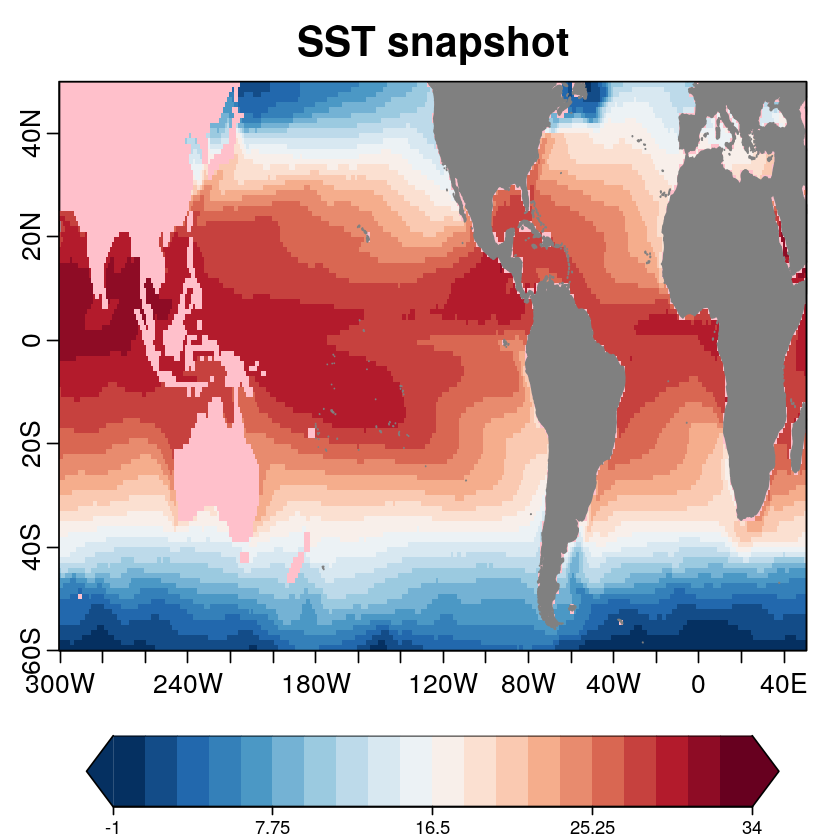

In [19]:
s2dv::PlotEquiMap( a511[1,1, 1,1,1, , ], 
			 lons, lats ,  
             toptitle= "SST snapshot", 
             cols=color, brks=interval2, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
             filled.continents = T) 

In [3]:
## Calculate Climatologies with s2dv clim function
#
a511.clim=s2dv::Clim(a511, obs, time_dim = "sdate", 
                dat_dim = c("dat", "member"),
                memb = F,
                ncores = 16)

a53d.clim=s2dv::Clim(a53d, obs, time_dim = "sdate", 
                dat_dim = c("dat", "member"),
                memb = F,
                ncores = 16)

In [12]:
str(a511.clim)

List of 2
 $ clim_exp: num [1, 1, 1:12, 1:110, 1:351] 3.79 3.49 3.31 3.07 2.68 ...
 $ clim_obs: num [1, 1, 1:12, 1:110, 1:351] 277 276 276 276 276 ...


In [ ]:
bias = a511.clim$clim_exp - a511.clim$clim_obs 

In [14]:
dim(a511.clim$clim_exp)

dat  var time  lat  lon 
   1    1   12  110  351

### Compute biases wrt hadisst SST and their seasonal means 

In [18]:
## Seasonal means
a53d.mjj =  s2dv::Season (a53d, time_dim = "time",5,5,7 ,ncores=16) 

a511.mjj =  s2dv::Season (a511, time_dim = "time",5,5,7 ,ncores=16) 

obs.mjj =  s2dv::Season (obs, time_dim = "time",5,5,7 ,ncores=16) 

In [11]:
dim(a53d.mjj)

time    dat    var member  sdate    lat    lon 
     1      1      1      5     11    110    351

### Bias                   package:s2dv                    R Documentation

Compute the Mean Bias

Description:

     The Mean Bias or Mean Error (Wilks, 2011) is defined as the mean
     difference between the ensemble mean forecast and the
     observations. It is a deterministic metric. Positive values
     indicate that the forecasts are on average too high and negative
     values indicate that the forecasts are on average too low. It also
     allows to compute the Absolute Mean Bias or bias without temporal
     mean. If there is more than one dataset, the result will be
     computed for each pair of exp and obs data.


In [49]:
bias.a53d <- Bias(exp = a53d.mjj, obs = obs.mjj-273.15, memb_dim = 'member')
bias.a511 <- Bias(exp = a511.mjj, obs = obs.mjj-273.15, memb_dim = 'member')

In [55]:
dim(bias.a511)

time  dat  var  lat  lon 
   1    1    1  110  351

In [52]:
range(bias.a511, na.rm = T)

[1] -3.122581  5.671173

In [53]:
######### Plot##################################
###########################################
min2=-3
max2=3
int2=(max2-min2)/20
interval2=seq(min2,max2,int2)
clim.palette(palette = "bluered")
color=clim.colors(20, palette = "bluered")

function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x295c6e00>
<environment: 0x2d865400>
attr(,"na_color")
[1] "pink"

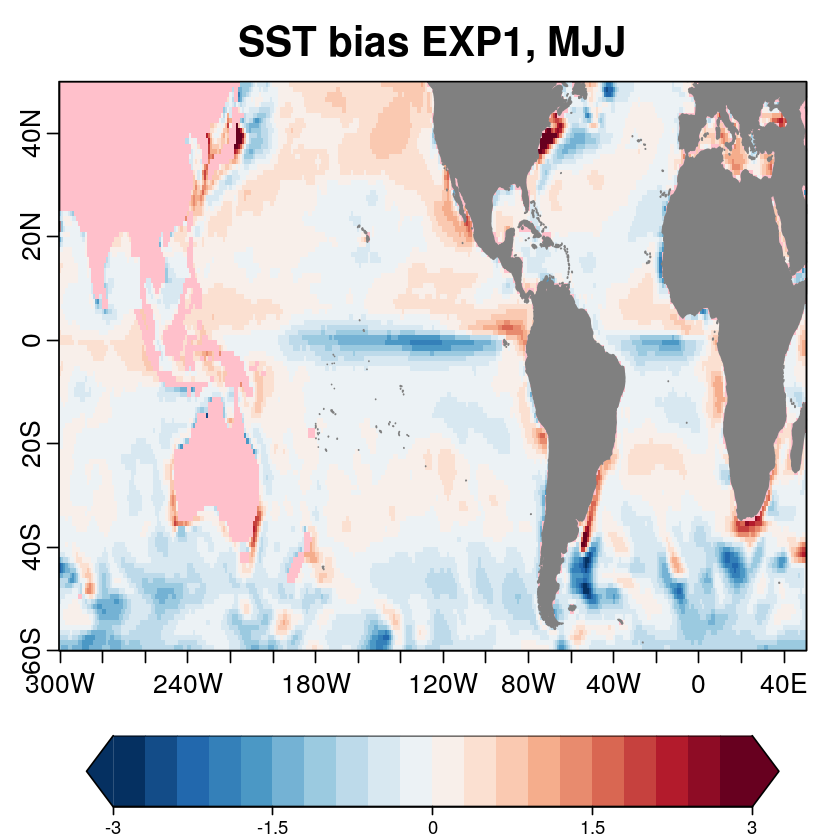

In [100]:
s2dv::PlotEquiMap( bias.a53d[1,1, 1, , ], 
			 lons, lats ,  
             toptitle= "SST bias EXP1, MJJ", 
             cols=color, brks=interval2, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
             filled.continents = T) 

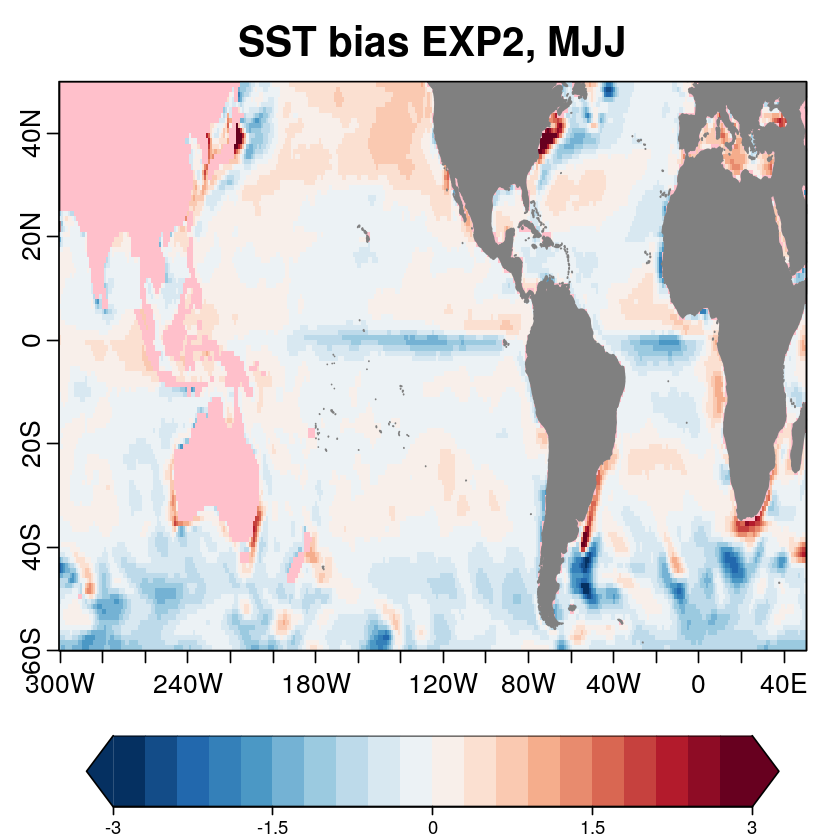

In [101]:
s2dv::PlotEquiMap( bias.a511[1,1, 1, , ], 
			 lons, lats ,  
             toptitle= "SST bias EXP2, MJJ", 
             cols=color, brks=interval2, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
             filled.continents = T) 


### Compute the Absolute Mean Bias Skill Score

Description:

     The Absolute Mean Bias Skill Score is based on the Absolute Mean
     Error (Wilks, 2011) between the ensemble mean forecast and the
     observations. It measures the accuracy of the forecast in
     comparison with a reference forecast to assess whether the
     forecast presents an improvement or a worsening with respect to
     that reference. The Mean Bias Skill Score ranges between minus
     infinite and 1. Positive values indicate that the forecast has
     higher skill than the reference forecast, while negative values
     indicate that it has a lower skill. Examples of reference
     forecasts are the climatological forecast (average of the
     observations), a previous model version, or another model. It is
     computed as 'AbsBiasSS = 1 - AbsBias_exp / AbsBias_ref'. The
     statistical significance is obtained based on a Random Walk test
     at the 95 and Tippett, 2016). If there is more than one dataset,
     the result will be computed for each pair of exp and obs data.


In [35]:
abs.bias.a511.mjj <- AbsBiasSS(a511.mjj, obs.mjj-273.15, a53d.mjj,
						   memb_dim = 'member', dat_dim='dat', ncores=16)


In [103]:
# PLot 
min2=-1
max2=1
int2=(max2-min2)/20
interval2=seq(min2,max2,int2)
clim.palette(palette = "bluered")
color=clim.colors(20, palette = "bluered")

function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x295c6e00>
<environment: 0x1587e7f8>
attr(,"na_color")
[1] "pink"

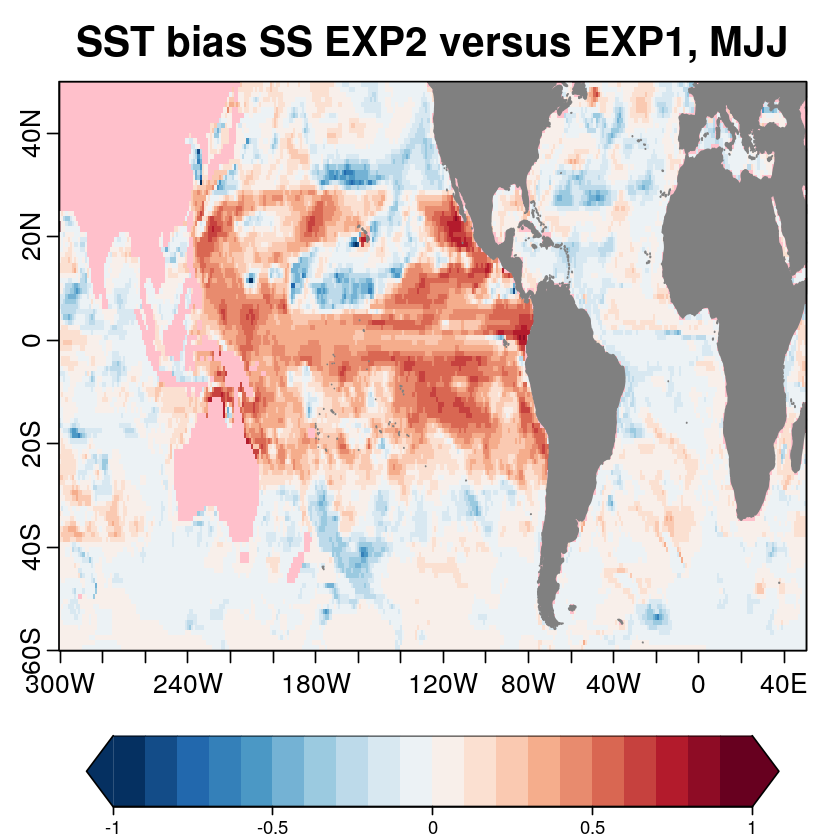

In [105]:
s2dv::PlotEquiMap( abs.bias.a511.mjj$biasSS[1, 1, 1, 1, , ], 
			 lons, lats ,  
             toptitle= "SST bias SS EXP2 versus EXP1, MJJ", 
             cols=color, brks=interval2, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
             filled.continents = T) 

### Calculate ACC score 

In [4]:
#### Calculate ACC score ##############################################################
#
## Anonalies
a511.ano = s2dv::Ano (a511, a511.clim$clim_exp,ncores=16)
a53d.ano = s2dv::Ano (a53d, a53d.clim$clim_exp,ncores=16)
obs.ano  = s2dv::Ano (obs,  a511.clim$clim_obs,ncores=16)

In [5]:
# Seasonal means of the anomalies
a511.ano.mjj = s2dv::Season ( a511.ano, time_dim = "time",5,5,7,ncores=16) 
a53d.ano.mjj = s2dv::Season ( a53d.ano, time_dim = "time",5,5,7,ncores=16)
 obs.ano.mjj = s2dv::Season ( obs.ano , time_dim = "time",5,5,7,ncores=16)

In [7]:
# Correlations between exps and obs 
a511.cor.mjj <- s2dv::Corr(s2dverification::Mean1Dim(a511.ano.mjj,4),
                           s2dverification::Mean1Dim(obs.ano.mjj,4),time_dim="sdate",dat_dim="dat",ncores=16)
                                                                
a53d.cor.mjj <- s2dv::Corr(s2dverification::Mean1Dim(a53d.ano.mjj,4),
                           s2dverification::Mean1Dim(obs.ano.mjj,4),time_dim="sdate",dat_dim="dat",ncores=16)

In [106]:
# Plot ACC
min=-1.
max=1.
int=(max-min)/20
interval=seq(min,max,int)
clim.palette(palette = "bluered")
color=clim.colors(20, palette = "bluered")


function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x295c6e00>
<environment: 0x293a7da8>
attr(,"na_color")
[1] "pink"

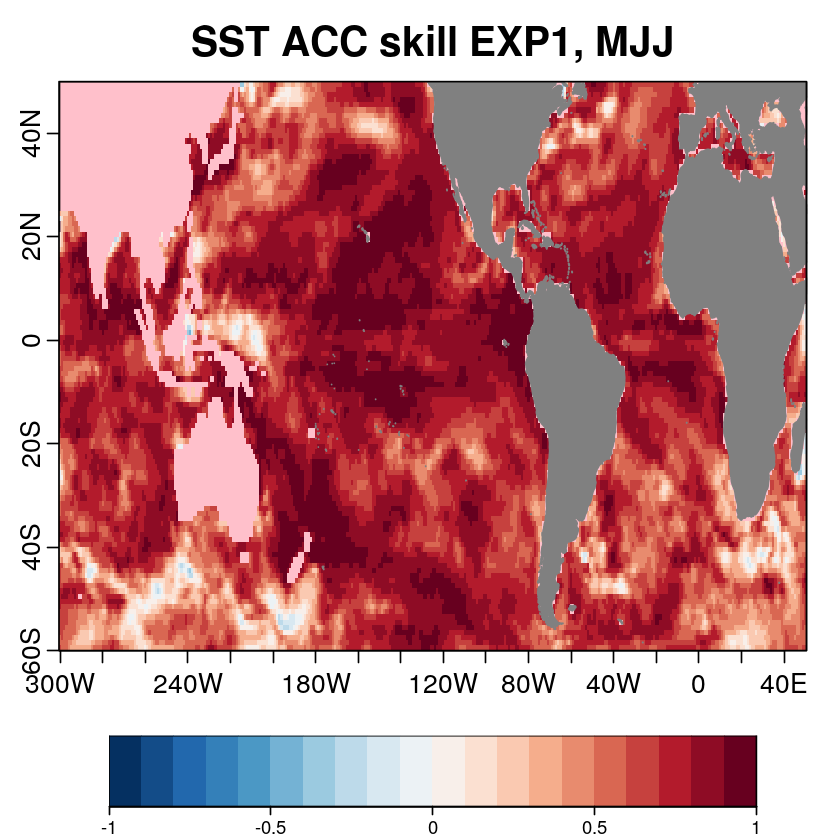

In [107]:
PlotEquiMap( a53d.cor.mjj$corr[1,1,1,1,,], 
             lons,lats,
             toptitle= "SST ACC skill EXP1, MJJ", 
             cols=color, brks=interval, drawleg = T,
             filled.continents = T) 

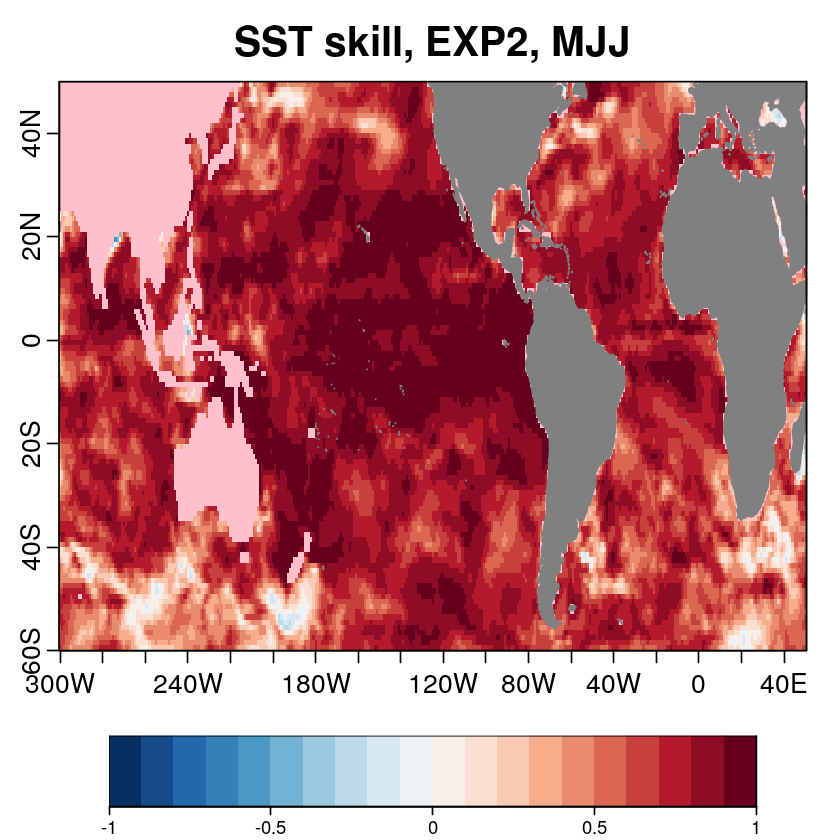

In [108]:
PlotEquiMap( a511.cor.mjj$corr[1,1,1,1,,], 
             lons,lats,
             toptitle= "SST skill, EXP2, MJJ", 
             cols=color, brks=interval, drawleg = T,
             filled.continents = T) 


### Compute Brier Skill Score 

In [64]:
dim(a511.ano.mjj)

time    dat    var member  sdate    lat    lon 
     1      1      1      5     11    110    351

In [89]:
# Removing NaNs first 
tmp1 =  a511.ano.mjj
tmp1 [ is.na (tmp1 )] = 0
tmp2 =  obs.ano.mjj
tmp2 [ is.na (tmp2 )] = 0
# bss <- UltimateBrier(a511.ano.mjj , obs.ano.mjj, 
a511.bss <- UltimateBrier(tmp1,tmp2, 
                     dat_dim = "dat",
                     quantile = TRUE,
                     thr = c(1/3, 2/3),
                     type = 'BSS')

In [90]:
tmp1 =  a53d.ano.mjj
tmp1 [ is.na (tmp1 )] = 0
tmp2 =  obs.ano.mjj
tmp2 [ is.na (tmp2 )] = 0
# bss <- UltimateBrier(a511.ano.mjj , obs.ano.mjj, 
a53d.bss <- UltimateBrier(tmp1,tmp2, 
                     dat_dim = "dat",
                     quantile = TRUE,
                     thr = c(1/3, 2/3),
                     type = 'BSS')

In [84]:
range(bss,na.rm = T )

[1] -1.8966667  0.9842857

In [85]:
dim(bss)

nexp nobs  bin time  var  lat  lon 
   1    1    3    1    1  110  351

In [110]:
#### Correlation #########################################
min=-1.
max=1.
int=(max-min)/20
interval=seq(min,max,int)
clim.palette(palette = "bluered")
color=clim.colors(20, palette = "bluered")


function (n) 
{
    x <- ramp(seq.int(0, 1, length.out = n))
    if (ncol(x) == 4L) 
        rgb(x[, 1L], x[, 2L], x[, 3L], x[, 4L], maxColorValue = 255)
    else rgb(x[, 1L], x[, 2L], x[, 3L], maxColorValue = 255)
}
<bytecode: 0x295c6e00>
<environment: 0x12e7c6c8>
attr(,"na_color")
[1] "pink"

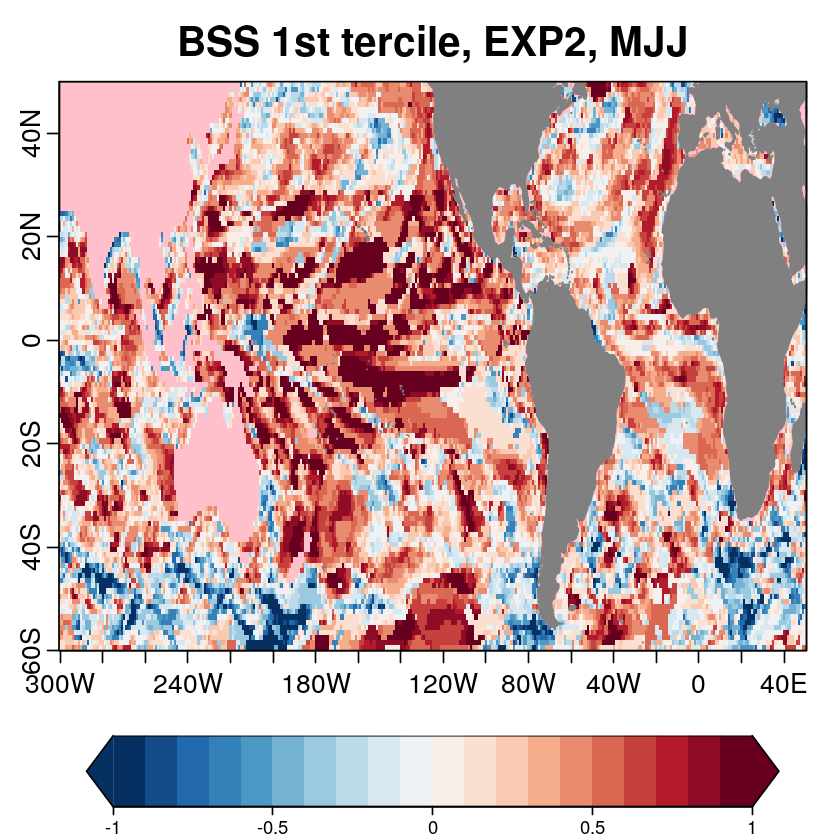

In [111]:
PlotEquiMap( a511.bss[1,1,1,1,1,,], 
             lons,lats,
             toptitle= "BSS 1st tercile, EXP2, MJJ", 
             cols=color, brks=interval, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
#              dots = dots.a53d.cor.mjj,
#              dot_size = 0.5,
             filled.continents = T) 

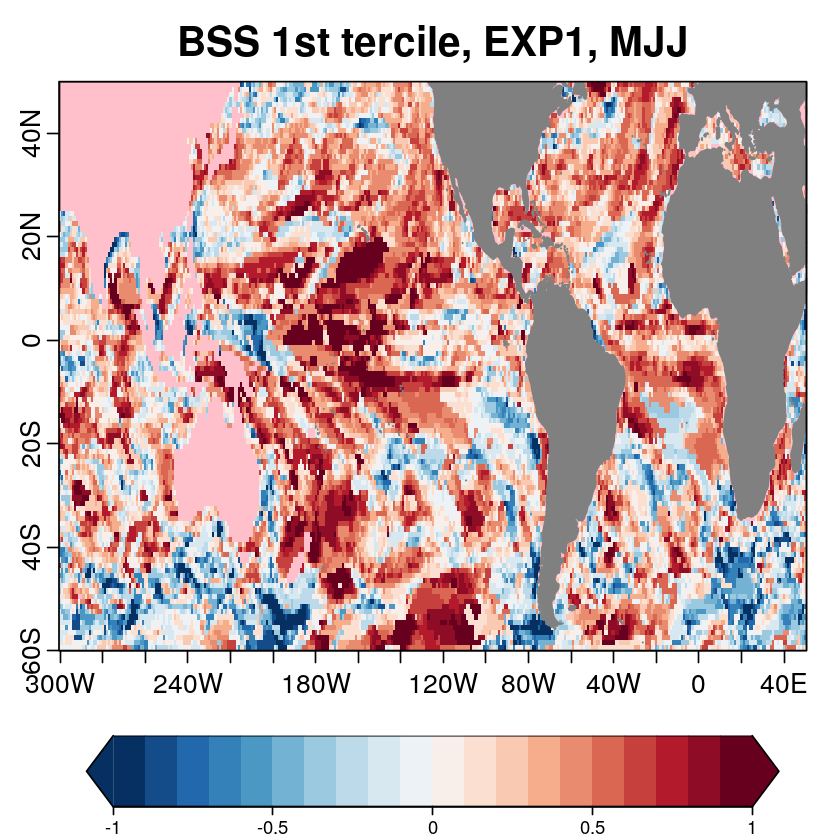

In [112]:
PlotEquiMap( a53d.bss[1,1,1,1,1,,], 
             lons,lats,
             toptitle= "BSS 1st tercile, EXP1, MJJ", 
             cols=color, brks=interval, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
#              dots = dots.a53d.cor.mjj,
#              dot_size = 0.5,
             filled.continents = T) 

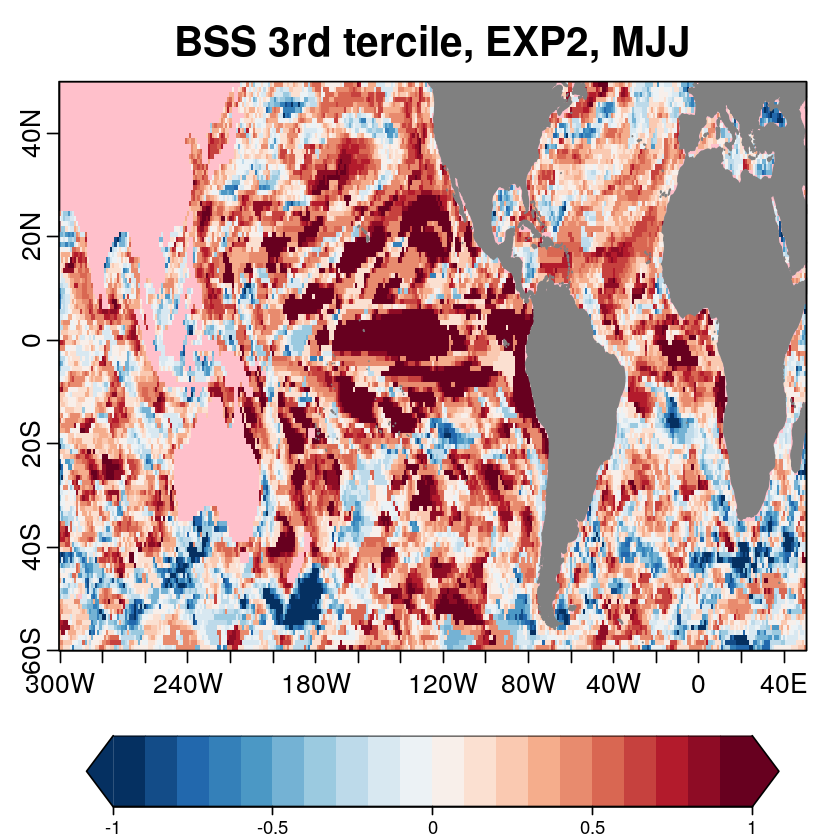

In [113]:
PlotEquiMap( a511.bss[1,1,3,1,1,,], 
             lons,lats,
             toptitle= "BSS 3rd tercile, EXP2, MJJ", 
             cols=color, brks=interval, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
#              dots = dots.a53d.cor.mjj,
#              dot_size = 0.5,
             filled.continents = T) 

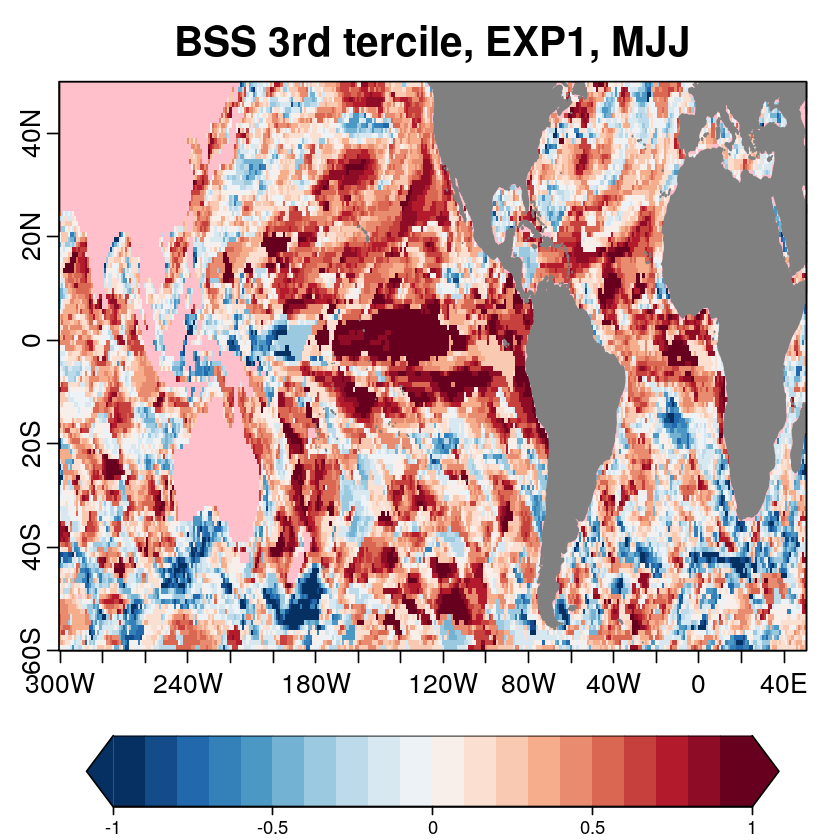

In [114]:
PlotEquiMap( a53d.bss[1,1,3,1,1,,], 
             lons,lats,
             toptitle= "BSS 3rd tercile, EXP1, MJJ", 
             cols=color, brks=interval, drawleg = T,
             triangle_ends = c(T,F), col_inf = color[1], col_sup = color[20],
#              dots = dots.a53d.cor.mjj,
#              dot_size = 0.5,
             filled.continents = T) 

In [115]:
# save.image ("SST_skill-bias-spatial-a511_a53d.Rdata")

In [2]:
load ("SST_skill-bias-spatial-a511_a53d.Rdata")